In [2]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011


In [3]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [4]:
# getting coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [5]:
# Reading Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [6]:
# Reading Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [7]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101219
1,Băneasa,Sector 1,"225,454",44.494012,26.080358
2,Berceni,Sector 4,"287,828",44.386430,26.128490
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [9]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest


In [16]:
# The code was removed by Watson Studio for sharing.

In [12]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id=HKVLR3NL0ENMEOXKLUPL1XSIRVVJVM51KKOVFTFD00UJGOZZ&client_secret=JP3QEIQTEBSGQL5IGKO5TI4N4WDEJI5PXJXSKPRFM4LUMHKZ&v=20200604&ll=44.4268, 26.1025&radius=1000&limit=100"

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 56 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,SalsaFit Gym,4cb9d2759552b60cdaffd58b,44.428260,26.104937,252,Gym / Fitness Center
1,Aviației,44.48579,26.101219,Zara,4b92514ff964a520d9f133e3,44.429212,26.104980,333,Clothing Store
2,Aviației,44.48579,26.101219,Emozia Manifesto,5b012eca345cbe002ca26b51,44.429218,26.103046,272,Coffee Shop
3,Aviației,44.48579,26.101219,Piața Unirii,4b5a17eef964a520baac28e3,44.426940,26.102514,15,Plaza
4,Aviației,44.48579,26.101219,Starbucks,5491a88f498e12011af1a3a7,44.429186,26.101656,273,Coffee Shop


In [13]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Coffee Shop,9
Romanian Restaurant,4
Café,4
Clothing Store,4
Hotel,4
Historic Site,3
Roof Deck,3
Ice Cream Shop,3
Plaza,3


In [14]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 22
Total number of Turkish restaurants: 1
Percentage of Turkish restaurants: 4.55%


0 neighborhoods do not have any Turkish restaurant


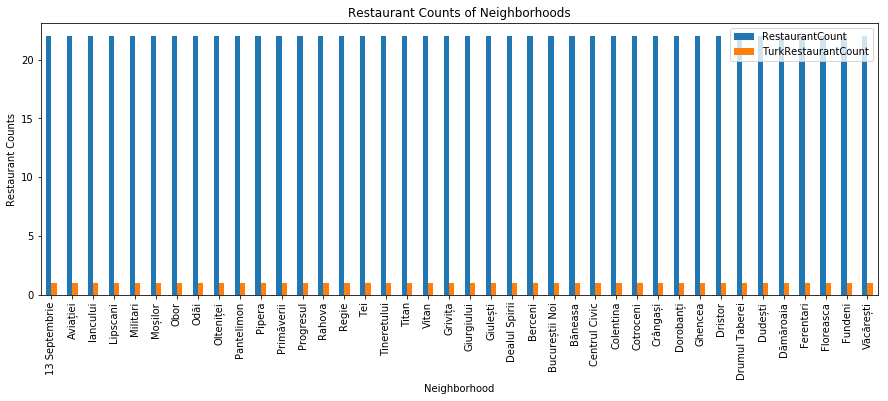

In [15]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [16]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,50368080e4b0aae9b35e0d2b,None,None
1,547a0c42498ecfcbffe8f85d,None,None
2,544e6bcb498e062a2230254c,None,None
3,4f0456104901a1400b1866d5,None,None
4,51a3aa5a498e75bcbfbc1a02,None,None


In [17]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Mica Elveție,50368080e4b0aae9b35e0d2b,44.42962,26.101671,320,Swiss Restaurant,None,None
1,Băneasa,44.494012,26.080358,Mica Elveție,50368080e4b0aae9b35e0d2b,44.42962,26.101671,320,Swiss Restaurant,None,None
2,Berceni,44.386430,26.128490,Mica Elveție,50368080e4b0aae9b35e0d2b,44.42962,26.101671,320,Swiss Restaurant,None,None
3,Bucureștii Noi,44.480413,26.042807,Mica Elveție,50368080e4b0aae9b35e0d2b,44.42962,26.101671,320,Swiss Restaurant,None,None
4,Centrul Civic,44.434300,26.094660,Mica Elveție,50368080e4b0aae9b35e0d2b,44.42962,26.101671,320,Swiss Restaurant,None,None


In [18]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,399,Doner Restaurant,None,None
1,Băneasa,44.494012,26.080358,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,399,Doner Restaurant,None,None
2,Berceni,44.386430,26.128490,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,399,Doner Restaurant,None,None
3,Bucureștii Noi,44.480413,26.042807,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,399,Doner Restaurant,None,None
4,Centrul Civic,44.434300,26.094660,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,399,Doner Restaurant,None,None


In [19]:
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [20]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

In [21]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 56 columns as below


,Neighborhood,Gym / Fitness Center,Clothing Store,Coffee Shop,Plaza,Women's Store,Swiss Restaurant,Ice Cream Shop,Roof Deck,Pizza Place,Rock Club,Mediterranean Restaurant,Fountain,Bar,Bookstore,Dessert Shop,Church,Hotel,Historic Site,Monastery,Middle Eastern Restaurant,Irish Pub,Wine Bar,Vietnamese Restaurant,Tattoo Parlor,Doner Restaurant,Park,Bagel Shop,Sporting Goods Shop,Cocktail Bar,Used Bookstore,Café,Brasserie,Beer Bar,Romanian Restaurant,Chocolate Shop,Beer Garden,Restaurant,Camera Store,Art Gallery,Lounge,Sushi Restaurant,Tea Room,Dance Studio,Steakhouse,Perfume Shop,Italian Restaurant,Greek Restaurant,Sandwich Place,Hostel,Toy / Game Store,Gastropub,Pub,Theater,Bakery,Palace,History Museum
0,13 Septembrie,2,4,9,3,1,1,3,3,2,1,2,1,1,2,1,1,4,3,2,1,1,2,1,1,1,1,2,2,1,1,4,1,2,4,2,1,2,1,1,3,1,1,1,1,1,1,2,1,1,1,2,1,1,1,2,1
1,Aviației,2,4,9,3,1,1,3,3,2,1,2,1,1,2,1,1,4,3,2,1,1,2,1,1,1,1,2,2,1,1,4,1,2,4,2,1,2,1,1,3,1,1,1,1,1,1,2,1,1,1,2,1,1,1,2,1
2,Berceni,2,4,9,3,1,1,3,3,2,1,2,1,1,2,1,1,4,3,2,1,1,2,1,1,1,1,2,2,1,1,4,1,2,4,2,1,2,1,1,3,1,1,1,1,1,1,2,1,1,1,2,1,1,1,2,1
3,Bucureștii Noi,2,4,9,3,1,1,3,3,2,1,2,1,1,2,1,1,4,3,2,1,1,2,1,1,1,1,2,2,1,1,4,1,2,4,2,1,2,1,1,3,1,1,1,1,1,1,2,1,1,1,2,1,1,1,2,1
4,Băneasa,2,4,9,3,1,1,3,3,2,1,2,1,1,2,1,1,4,3,2,1,1,2,1,1,1,1,2,2,1,1,4,1,2,4,2,1,2,1,1,3,1,1,1,1,1,1,2,1,1,1,2,1,1,1,2,1


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
1,Aviației,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
2,Berceni,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
3,Bucureștii Noi,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
4,Băneasa,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
5,Centrul Civic,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
6,Colentina,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
7,Cotroceni,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
8,Crângași,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza
9,Dealul Spirii,100,Coffee Shop,Romanian Restaurant,Clothing Store,Hotel,Café,Lounge,Ice Cream Shop,Roof Deck,Historic Site,Plaza


/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:2882: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  ax.set_ylim([0, dvw])


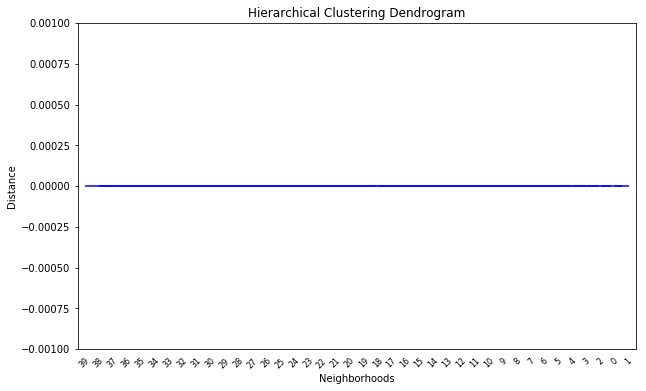

In [23]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))


In [24]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101219,0,Coffee Shop,Hotel,Café
1,Băneasa,Sector 1,"225,454",44.494012,26.080358,0,Coffee Shop,Hotel,Café
2,Berceni,Sector 4,"287,828",44.386430,26.128490,0,Coffee Shop,Hotel,Café
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807,0,Coffee Shop,Hotel,Café
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,0,Coffee Shop,Hotel,Café


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [25]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   Coffee Shop                                 35
1                   Coffee Shop                                  1
2                   Coffee Shop                                  1
3                   Coffee Shop                                  1
4                   Coffee Shop                                  1
5                   Coffee Shop                                  1


,,Neighborhood Count
NeighborhoodCluster,2nd Most Common Restaurant,
0,Hotel,35
1,Hotel,1
2,Hotel,1
3,Hotel,1
4,Hotel,1
5,Hotel,1
